<a href="https://colab.research.google.com/github/CSSamarasinghe/SE4050_Assignment/blob/IT21263194/after_data_set_change_improvement%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-reviews-for-sentianalysis-finegrained-csv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2078107%2F3499094%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241003%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241003T164549Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D25a30a2ad799910d48f45f67793fb1d09f31560ae3773fa14870108018fa213261ae62aeb020867952a30d8094a21359c2546a6475193ac986bc2645a191d848c7223dbd5c68600aeb8f17d5a979be9750827328816b6743cf0d74ca79e5a28878f8606f4d3cd2176678d18b8a70a20bbf9be8037aa238d4b56bd1a0ba1a8d1fb4003bbd12f51fa6d438aaa8a7e8fa90a9291e62969f7df78c34dc6a71c76fb2f1c11e2964127136ec4d5554e9f1bdd7c530f8ddf987a08dd6cb91a849e4e98a2089149d22cb00ca687688c756071af4270e392fd79699c1f4a35ca16597523ca8bfe37fea11d5911465ea51d6eb17c1e3663da806763c8ef4e96e1f0a9ae9ab'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 654512809 bytes downloaded
Downloaded and uncompressed: amazon-reviews-for-sentianalysis-finegrained-csv
Data source import complete.


In [ ]:
import pandas as pd

# Load the dataset
train = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/train.csv')
test = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/test.csv')

# Check the column names
print("Training data set")
print(train.columns)
print(train.shape)

print("Testing data set")
print(test.columns)
print(test.shape)

Training data set
Index(['class_index', 'review_title', 'review_text'], dtype='object')
(3000000, 3)
Testing data set
Index(['class_index', 'review_title', 'review_text'], dtype='object')
(650000, 3)


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.preprocessing.text import Tokenizer
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import OneHotEncoder

# Load the dataset
train_data = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/train.csv')
test_data = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/test.csv')

# Reduce the dataset to a manageable size (e.g., taking the first 1000 samples)
train_data = train_data.sample(n=50000, random_state=42)  # Randomly sample 1000 rows from the training data
test_data = test_data.sample(n=20000, random_state=42)


# Set a maximum vocabulary size
vocab_size = 10000

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_data['review_text'])

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_data['review_text'])
X_test = tokenizer.texts_to_sequences(test_data['review_text'])

# Directly take the numeric values from class_index
Y_train = train_data['class_index'].values
Y_test = test_data['class_index'].values

# If needed, one-hot encode the labels for multi-class classification
Y_train_reshaped = Y_train.reshape(-1, 1)
Y_test_reshaped = Y_test.reshape(-1, 1)

# Use sparse_output instead of sparse
encoder = OneHotEncoder(sparse_output=False)
Y_train_onehot = encoder.fit_transform(Y_train_reshaped)
Y_test_onehot = encoder.transform(Y_test_reshaped)

# Print the shapes to confirm
print(f'X_train shape: {len(X_train)}, Y_train shape: {Y_train_onehot.shape}')
print(f'X_test shape: {len(X_test)}, Y_test shape: {Y_test_onehot.shape}')

# Pad the sequences and convert to tensors
X_train_padded = pad_sequence([torch.tensor(seq) for seq in X_train], batch_first=True, padding_value=0)
X_test_padded = pad_sequence([torch.tensor(seq) for seq in X_test], batch_first=True, padding_value=0)

# Adjust the input size
input_size = vocab_size + 1  # Vocabulary size (plus 1 for padding)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_padded, torch.tensor(Y_train_onehot, dtype=torch.float32))
test_dataset = TensorDataset(X_test_padded, torch.tensor(Y_test_onehot, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

X_train shape: 50000, Y_train shape: (50000, 5)
X_test shape: 20000, Y_test shape: (20000, 5)


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2024-10-04 16:47:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-10-04 16:47:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-10-04 16:47:50--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

NameError: name 'load_glove_embeddings' is not defined

In [ ]:
import numpy as np

def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.array(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Load 100-dimensional GloVe embeddings
glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')
print(f'Loaded {len(glove_embeddings)} word vectors.')


Loaded 400000 word vectors.


In [ ]:
# Prepare embedding matrix
embedding_dim = 100  # Dimension of GloVe vectors
embedding_matrix = np.zeros((input_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < input_size:  # Ensure we don't exceed the matrix size
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, embedding_matrix, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))  # Load pre-trained weights
        self.lstm1 = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.fc1 = nn.Linear(hidden_size, hidden_size)  # Additional fully connected layer
        self.fc2 = nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        # Remove torch.tanh(x) to simplify to ReLU only and dropout
        x, _ = self.lstm2(x)

        x = self.dropout(x[:, -1, :])  # Apply dropout to the last time step output
        x = self.fc1(x)  # First fully connected layer
        x = torch.relu(x)  # ReLU activation function
        x = self.fc2(x)  # Output layer
        return x


In [ ]:
import numpy as np
import torch
import torch.nn as nn

# Load GloVe embeddings and create embedding_matrix (with 100d GloVe embeddings)
# Ensure that you load the 'glove.6B.100d.txt' file and prepare the embedding_matrix accordingly

# Set hyperparameters
num_epochs = 5  # Number of training epochs
embedding_dim = 100  # Dimension of GloVe embeddings (using 100d GloVe file)
hidden_size = 64  # Number of LSTM hidden units
output_size = len(set(Y_train))  # Number of classes based on your training labels
learning_rate = 0.001  # Learning rate for the optimizer

# Ensure input_size is defined based on your tokenizer
input_size = len(tokenizer.word_index) + 1  # Vocabulary size (plus padding)

# Initialize the model **before** defining the optimizer
model = LSTMModel(vocab_size=10001,
                  embedding_dim=embedding_dim,
                  hidden_size=hidden_size,
                  output_size=output_size,
                  embedding_matrix=embedding_matrix,  # Ensure this is defined with 100d GloVe embeddings
                  dropout_rate=0.5)  # You can adjust the dropout rate as needed

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Now, you can proceed to the training loop


Epoch [1/5], Loss: 1.6098
Accuracy on test set after epoch [1/5]: 19.82%
Epoch [2/5], Loss: 1.6097
Accuracy on test set after epoch [2/5]: 20.05%
Epoch [3/5], Loss: 1.6096
Accuracy on test set after epoch [3/5]: 19.86%
Epoch [4/5], Loss: 1.6096
Accuracy on test set after epoch [4/5]: 19.86%
Epoch [5/5], Loss: 1.6095
Accuracy on test set after epoch [5/5]: 19.91%


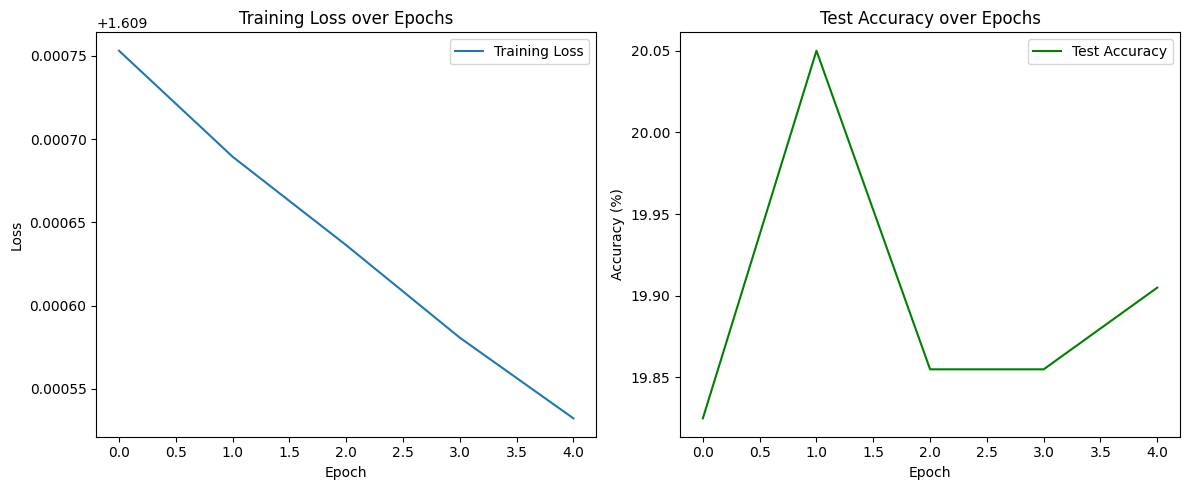

In [12]:
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to track loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize loss for the epoch

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Clear the gradients

        inputs = inputs.long()  # Ensure inputs are long type for embedding

        outputs = model(inputs)  # Forward pass

        # Compute loss (labels should be LongTensor of class indices)
        loss = criterion(outputs, labels.argmax(dim=1))  # Use argmax to get class indices from one-hot labels

        # Backward pass and optimization
        loss.backward()  # Backward pass
        optimizer.step()  # Optimization step

        epoch_loss += loss.item()  # Accumulate loss for this batch

    avg_loss = epoch_loss / len(train_loader)  # Calculate average loss for the epoch
    train_losses.append(avg_loss)  # Store the average loss for plotting
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # After each epoch, evaluate on the test set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for inputs, labels in test_loader:
            inputs = inputs.long()  # Ensure inputs are long type for embedding

            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get the predicted class

            total += labels.size(0)  # Total number of labels
            correct += (predicted == labels.argmax(dim=1)).sum().item()  # Correct predictions

    accuracy = (correct / total) * 100  # Calculate accuracy as a percentage
    test_accuracies.append(accuracy)  # Store the accuracy for plotting
    print(f'Accuracy on test set after epoch [{epoch + 1}/{num_epochs}]: {accuracy:.2f}%')

# Plot training loss and test accuracy over epochs
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
